# **MLFA A5:Geospatial data classification using Principal component analysis**				



Dataset='sst.mon.mean.nc'

The dataset contains monthly global sea surface temperature data. There is a region over pacific ocean called Nino 3.4 (longitude=[170:290] ,latitude= [84:96]). If the average sst ANOMALY(True value- long term mean) value for the region for a month is greater than .5 then it is called 'El-nino' if less than -.5 then 'La-nina'. 

You need to perform classification task using PCA and NN classifier to classify the input data into 'El-nino' and 'La-nina'.

The steps to be performed are:

1)Dataset preparation and visualization

1.a)Load dataset using NetCDF4

1.b)Separate lon,lat,sst and time in different variables

1.c)Plot data on Basemap taking the mean Nino 3.4 region ([170:290] for longitude and [84:96] for latitude) over the years

1.d)Prepare sst anomaly (sst value - mean sst value) for the whole dataset as model input

1.e)Calculate sst anomaly for the nino 3.4 region

1.f)Calculate mean nino 3.4 sst anomaly for each year

1.g)Detrend mean nino 3.4 sst anomaly

1.h)Prepare labels such that, if mean nino 3.4 sst anomaly value >.5 then 'El-nino' , mean nino 3.4 sst anomaly value <.5 then 'La-nina', discard the rest.

1.i)Transform masked array into numpy array by replacing nan values by 0.

1.j)Split into training and testing set with test set fraction as .33

2)PCA

2.a)Define and fit PCA

2.b)Transform training and testing set using PCA

2.c)Plot mean PCA map

2.d)Plot explained variance and variance ratio on graph

3)Classification

3.a)Create a device variable which will be used to shift model and data to GPU if available

3.b)Define pytorch NN classifier which reflects highest testing accuracy(around .99) with minimum number of layers. Plot the accuracy vs #layers graph to prove that your model is best.

3.c)Create a dataloader object which will create batches of data.

3.d)Train the classifier with batch sizes (16,32,64,128), learning rates (.001,.002,.003.01,.02,.03), optimizers (Adam, SGD) using GridSearch to find best configuration. Use earlystopping criteria to stop training.

3.e)Report prediction accuracy and confusion matrix

3.f)Randomly select 5 maps from testing set, plot them on map, predict classes using their PCA data and report them along with their true label.

In [ ]:
# %%capture
!pip install netCDF4
!pip install basemap
!pip uninstall matplotlib
!pip install matplotlib==3.2.2

In [ ]:
# Imports
import requests
import numpy as np
import netCDF4 as nc
from scipy import signal    
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [ ]:
filename = 'sst.mon.mean.nc'
url = 'https://psl.noaa.gov/repository/entry/get/sst.mon.mean.nc?entryid=synth%3Ae570c8f9-ec09-4e89-93b4-babd5651e7a9%3AL0NPQkUvc3N0Lm1vbi5tZWFuLm5j'

response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

In [ ]:
# 1(a) Load dataset using NetCDF4
fh = nc.Dataset('sst.mon.mean.nc', mode='r')

In [ ]:
# 1(b) Separate lon,lat,sst and time in different variables
lon = fh.variables['lon'][:]
lat = fh.variables['lat'][:]
sst = fh.variables['sst'][:]  #time X lat x lon
time = fh.variables['time'][:]

In [ ]:
# Checking Shapes
print(lon.shape)
print(lat.shape)
print(time.shape)
print(sst.shape)

(360,)
(180,)
(1587,)
(1587, 180, 360)


In [ ]:
# 1(c) Plot data on Basemap taking the Nino 3.4 region ([170:290] for longitude and [84:96] for latitude)

def plot_map(lon,lat,data):
    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(fh.variables['lat'][:]), urcrnrlat=np.max(fh.variables['lat'][:]),
            llcrnrlon=np.min(fh.variables['lon'][:]), urcrnrlon=np.max(fh.variables['lon'][:]), )
    lons,lats= np.meshgrid(lon,lat)
    x,y = m(lons,lats)    
    m.drawcoastlines()
    levels = np.linspace(min(np.unique(data)),max(np.unique(data)),21)
    temp = m.contourf(x,y,data,levels=levels,cmap='seismic')
    cb = m.colorbar(temp,"bottom", size="15%", pad="10%")
    plt.title('Sea Surface Temperature of NINO3.4')
    cb.set_label('sst')
    plt.show()

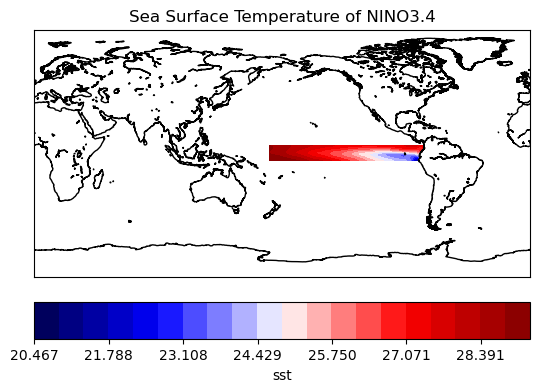

In [ ]:
# 1(c) Plot the mean data over the years for the selected region on Basemap
lon_region = lon[170:290]
lat_region = lat[84:96]
sst_region = sst[:,84:96,170:290]
sst_region_mean = sst_region.mean(axis=0)
# print(lon_region.shape)
# print(lat_region.shape)
# print(sst_region.shape)
# print(sst_region_mean.shape)
plot_map(lon_region,lat_region,sst_region_mean)

In [ ]:
# 1(d) Prepare sst anomaly (sst value - mean sst value) for the whole dataset as model input 
X = sst_region - sst_region_mean
print(X.shape)

(1587, 12, 120)


In [ ]:
# 1(e) Calculate sst anomaly for the nino 3.4 region
nino_3_4_sst_anomaly = X[3:] #(skipping  3 months to properly reshape data)
print(nino_3_4_sst_anomaly.shape)

(1584, 12, 120)


In [ ]:
# 1(f) Calculate spatial mean nino 3.4 sst anomaly for each year
mean_nino_3_4_sst_anomaly = np.mean(nino_3_4_sst_anomaly.reshape(-1, 12, nino_3_4_sst_anomaly.shape[1], nino_3_4_sst_anomaly.shape[2]), axis=1)
print(mean_nino_3_4_sst_anomaly.shape) #yearly data

(132, 12, 120)


In [ ]:
# mean_nino_3_4_sst_anomaly.shape, mean_nino_3_4_sst_anomaly_detrend.shape, mean_nino_3_4_sst_anomaly_detrend.reshape(-1).shape

(132, 12, 120)


Text(0.5, 1.0, 'Detrended Mean Nino 3.4 SST Anomaly')

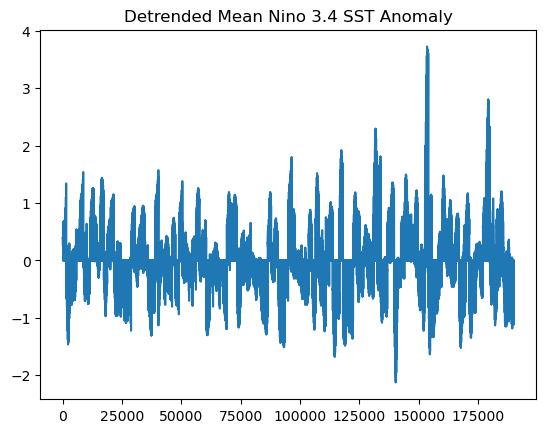

In [ ]:
# Detrend mean nino 3.4 sst anomaly
mean_nino_3_4_sst_anomaly_detrend = signal.detrend(mean_nino_3_4_sst_anomaly, axis=0)
print(mean_nino_3_4_sst_anomaly_detrend.shape)

# Plot detrended mean_nino_3_4_sst_anomaly
plt.plot(mean_nino_3_4_sst_anomaly_detrend.reshape(-1))
plt.title('Detrended Mean Nino 3.4 SST Anomaly')

In [ ]:
mean_nino_3_4_sst_anomaly_detrend.shape

(132, 12, 120)

In [ ]:
mean_nino_3_4_sst_anomaly_detrend.reshape(-1).shape

(190080,)

In [ ]:
X.shape, mean_nino_3_4_sst_anomaly_detrend.shape

((1587, 12, 120), (132, 12, 120))

In [ ]:
X[0].mean(), X[1].mean(), X[2].mean(), X[3].mean()

(-0.25988580101700354,
 0.4953587331906067,
 0.6407876325494667,
 1.4892921417684848)

In [ ]:
# 1(h) Prepare labels such that, if mean nino 3.4 sst anomaly value >.5 then 'El-nino' , mean nino 3.4 sst anomaly value -<.5 then 'La-nina' and the other values will be discarded. Prepare the corresponding input values also.

def prepare_model_input(mean_nino_3_4_sst_anomaly_detrend, X):
    index = []
    ENSO_label = []

    for i in range(X.shape[0]):
      if i < 3:
        if X[i].mean() > 0.5:
          index.append(i)
          ENSO_label.append('El-nino')
        elif X[i].mean() < -0.5:
          index.append(i)
          ENSO_label.append('La-nina')
      else:
        yr_no = (i-3)//12
        mean_anomaly_val=mean_nino_3_4_sst_anomaly_detrend[yr_no].mean()
        if mean_anomaly_val > 0.5:
          index.append(i)
          ENSO_label.append('El-nino')
        elif mean_anomaly_val < -0.5:
          index.append(i)
          ENSO_label.append('La-nina')
    
    X = X[index]
    X = X.reshape(X.shape[0], -1)
    y = np.array(ENSO_label)
    return (X, y)


In [ ]:
# X.shape, mean_nino_3_4_sst_anomaly_detrend.shape

In [ ]:
X_data,y_data=prepare_model_input(mean_nino_3_4_sst_anomaly_detrend, X)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(517, 1440)
(517,)


In [ ]:
# X_data

In [ ]:
#1 (i) Transform masked array into numpy array by replacing nan values by 0.
import math

def transform_masked_array(X):
  X = np.ma.filled(X, fill_value=0)
  return X

X=transform_masked_array(X_data)
y=y_data    

In [ ]:
X.shape, y.shape

((517, 1440), (517,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((346, 1440), (171, 1440), (346,), (171,))

Training Set


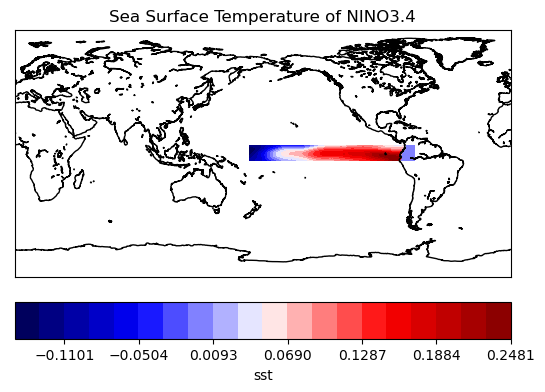

Testing Set


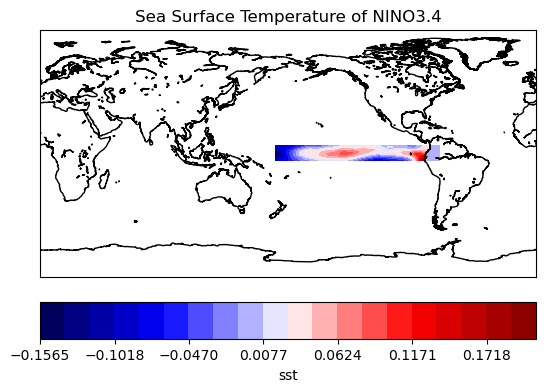

In [ ]:
#Plot mean training and testing set on map
print('Training Set')
plot_map(lon_region,lat_region,X_train.reshape(-1,12,120).mean(axis=0))
print('Testing Set')
plot_map(lon_region,lat_region,X_test.reshape(-1,12,120).mean(axis=0))

In [ ]:
# Define and fit PCA
from sklearn.decomposition import PCA

# Define number of components for PCA
n_components = 150

# Create PCA object and fit to training data
pca = PCA(n_components=n_components)

In [ ]:
#Transform training and testing set using PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
X_train_pca.shape, X_test_pca.shape

((346, 150), (171, 150))

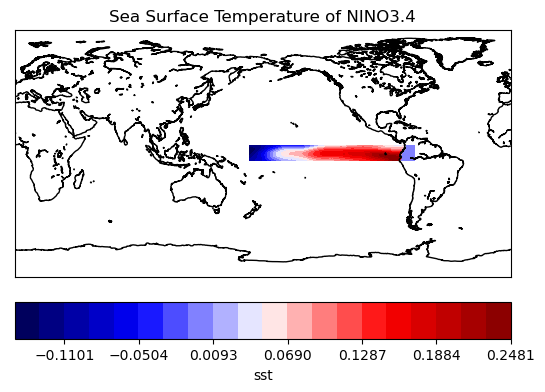

In [ ]:
#Plot mean PCA map
plot_map(lon_region,lat_region,X_train_pca.reshape(-1,12,120).mean(axis=0))

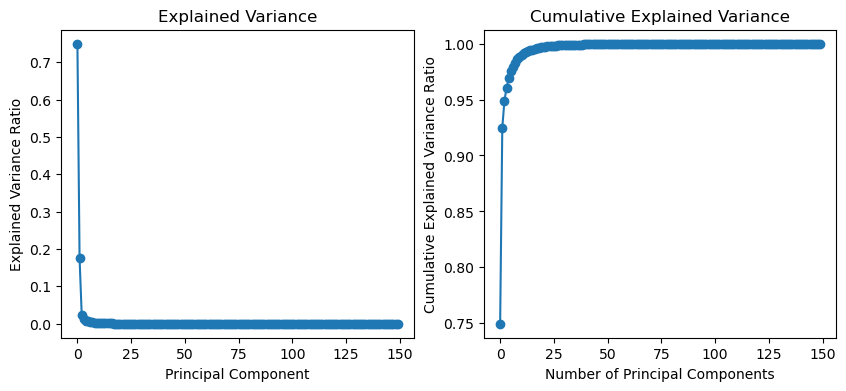

In [ ]:
# Plot explained variance and variance ratio on graph

import matplotlib.pyplot as plt

# Get explained variance ratios for each principal component
explained_variance_ratios = pca.explained_variance_ratio_

# Get total explained variance
total_explained_variance = sum(explained_variance_ratios)

# Get cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(explained_variance_ratios)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot explained variance on ax1
ax1.plot(explained_variance_ratios, 'o-')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance')

# Plot cumulative explained variance on ax2
ax2.plot(cumulative_explained_variance_ratios, 'o-')
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance')

plt.show()

In [ ]:
from tqdm.notebook import tqdm
import torch

# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define PyTorch NN classifier which reflects highest testing accuracy (around .99) with a minimum number of layers.

class FFN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) # input layer to hidden layer
        self.relu = torch.nn.ReLU() # activation function
        self.fc2 = torch.nn.Linear(hidden_size, output_size) # hidden layer to output layer
        self.softmax = torch.nn.Softmax(dim=1) # final output activation function

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)

# First create a PyTorch dataset from the numpy train data
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create a dataloader object which will create batches of data
batch_size = 64

# First create a pytorch dataset from the numpy train data
dataset_train = CustomDataset(X_train_pca, train_labels)
# Create a dataloader object which will create batches of data
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [ ]:
# Train the classifier
num_epochs = 50
learning_rate = 0.01

# Instantiate Model
model = FFN(X_train_pca.shape[1], 512, 2)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 10 mini-batches
            print(f'Epoch {epoch+1}, Batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

print('Training complete')

Epoch 1, Batch 1: loss = 0.0054
Epoch 2, Batch 1: loss = 0.0035
Epoch 3, Batch 1: loss = 0.0034
Epoch 4, Batch 1: loss = 0.0034
Epoch 5, Batch 1: loss = 0.0031
Epoch 6, Batch 1: loss = 0.0033
Epoch 7, Batch 1: loss = 0.0033
Epoch 8, Batch 1: loss = 0.0033
Epoch 9, Batch 1: loss = 0.0033
Epoch 10, Batch 1: loss = 0.0033
Epoch 11, Batch 1: loss = 0.0037
Epoch 12, Batch 1: loss = 0.0034
Epoch 13, Batch 1: loss = 0.0031
Epoch 14, Batch 1: loss = 0.0035
Epoch 15, Batch 1: loss = 0.0031
Epoch 16, Batch 1: loss = 0.0033
Epoch 17, Batch 1: loss = 0.0033
Epoch 18, Batch 1: loss = 0.0034
Epoch 19, Batch 1: loss = 0.0031
Epoch 20, Batch 1: loss = 0.0034
Epoch 21, Batch 1: loss = 0.0031
Epoch 22, Batch 1: loss = 0.0032
Epoch 23, Batch 1: loss = 0.0033
Epoch 24, Batch 1: loss = 0.0033
Epoch 25, Batch 1: loss = 0.0033
Epoch 26, Batch 1: loss = 0.0031
Epoch 27, Batch 1: loss = 0.0031
Epoch 28, Batch 1: loss = 0.0034
Epoch 29, Batch 1: loss = 0.0031
Epoch 30, Batch 1: loss = 0.0031
Epoch 31, Batch 1: 

In [ ]:
# Report prediction accuracy and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix

# Move the model to the CPU
model.to('cpu')

# Get the predicted labels for the test data
test_inputs = torch.tensor(X_test_pca, dtype=torch.float32)
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_predicted = torch.argmax(test_outputs, dim=1)

# Convert the predicted labels back to string labels
test_predicted_labels = label_encoder.inverse_transform(test_predicted.numpy())

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, test_predicted_labels)
conf_matrix = confusion_matrix(y_test, test_predicted_labels)

print(f'Testing accuracy: {accuracy:.4f}')
print('Confusion matrix:')
print(conf_matrix)

Testing accuracy: 0.9649
Confusion matrix:
[[83  4]
 [ 2 82]]


In [ ]:
#randomly select 5 maps from testing set, plot them on map, predict classes using their PCA data and report them along with their true label.
import random
import matplotlib.pyplot as plt

# Randomly select 5 maps from the testing set
test_indices = list(range(len(y_test)))
random.shuffle(test_indices)
test_indices = test_indices[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(test_indices):
    # Get the PCA data for the map
    pca_data = X_test_pca[idx]

    # Plot the map
    axes[i].imshow(X_test_pca[idx], cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'Map {i+1}')

    # Get the predicted class for the map
    test_input = torch.tensor(pca_data, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        test_output = model(test_input)
        test_predicted = torch.argmax(test_output, dim=1).item()

    # Report the predicted and true class labels
    predicted_label = label_encoder.inverse_transform(test_predicted)
    true_label = y_test[idx]
    print(f"Map {i+1}: Predicted class: {predicted_label}, True class: {true_label}")
